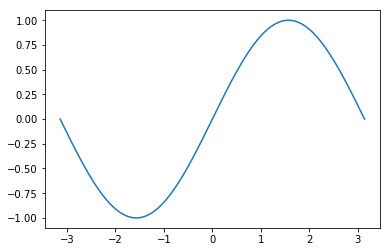

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plot_utility as pu

x = np.linspace(-np.pi, np.pi, 1000)
y = np.sin(x)

plt.plot(x, y)
plt.show()

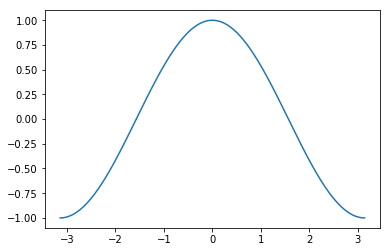

In [2]:
y = np.cos(x)
plt.plot(x, y)
plt.show()

Noto Sans CJK JP is found


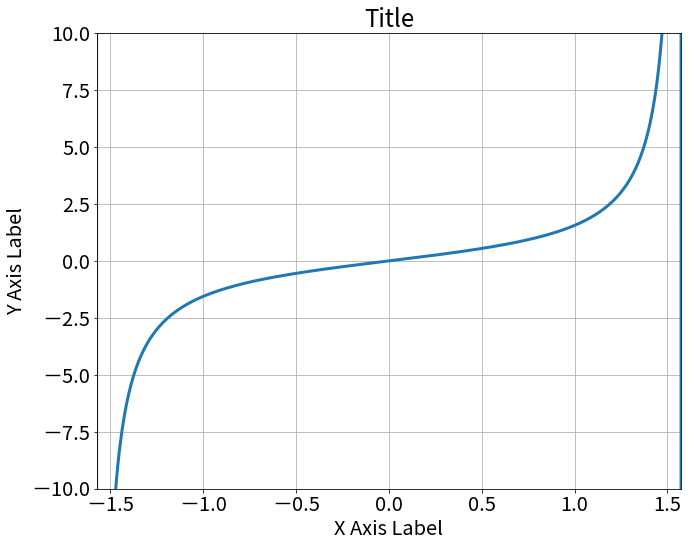

In [3]:
y = np.tan(x)
ax1 = pu.plot_1_graph(fontsize=20,
                      figsize=(10, 8),
                      graph_title="Title",
                      graph_title_size=None,
                      xlabel="X Axis Label", ylabel="Y Axis Label",
                      axis_label_size=None,
                      legend_size=17,
                      xlim=(-np.pi/2, np.pi/2),
                      ylim=(-10, 10),
                      xtick=None,
                      ytick=None,
                      xtick_size=None, ytick_size=None,
                      linewidth=3)
ax1.plot(x, y)
plt.show()

In [4]:
np.arctan(0)

0.0

# BT.2407 の手法調査

## A2.4 Lightness mapping

* **focal point** なる変換点(焦点)を決める。
* focal point は 横軸 Chroma, 縦軸 Lightness の平面で $L_{focal}^*, C_{focal}^*$ の2種類ある
* focal point を求めるために、最初に BT.2020 と BT.709 の **cups** を推定する
  * cups とは与えられた Hue にて最大の chroma をもつ色である
* BT.709 と BT.2020 の cups を通る直線と Lightness の軸との交点を $L_{cusp}^*$ と定義する
* $C_{focal}^*$ は 上記の直線と Chroma の軸との交点の **絶対値** である。
* $L_{focal}^*$ は $L_{cusp}^*$ を limited range? にしたものである。57.47～92.74。
 * chroma の loss やら を防ぐため
 * 具体的な値は Figure A2-4 参照
 
 ![fig_2_4](./doc/img/fig24.PNG)

## A2.5 Hue mapping

* 単純に Hue を維持したままのマッピングはイマイチ
* 特に Yellow は a*b* 平面で確認するとメッチャ Chroma が小さくなる
* なのでひと手間かけるよん

* ひと手間かけない場合は 式2-3, っかける場合は 式2-4 で変換する
* 式2-3 の $r$ は Lightness Mapping と合わせていい感じに行くように調整する



# BT.2407 Annex2 の実装

## とりあえず L\*a\*b* 空間に慣れよう

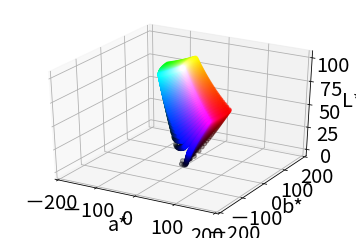

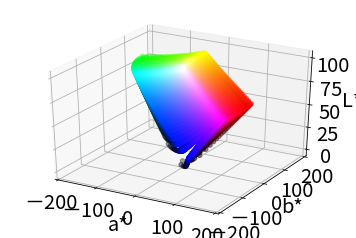

In [5]:
import color_science_study as css
css.plot_lab_color_space('ITU-R BT.709', 33)
css.plot_lab_color_space('ITU-R BT.2020', 33)

## Chroma-Lightness 平面をプロットしてみる

RGBMYC の Primary の Yを振って L\*a\*b\* でプロットしてみる。

data は以下の2種類必要か？

* black から cusp に伸びるやつ
* white から cusp に伸びるやつ

Red の例は以下

```
r = [(0, 0, 0), (0.333, 0.0, 0.0), (0.666, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.333, 0.333), (1.0, 0.666, 0.666), (1.0, 1.0, 1.0)]
```



## ベジェ曲線

\begin{align}
x &= (1 - t)^2 x_0 + 2 (1-t) t x_1 + t^2 x_2 \\
x &= (1 - 2t + t^2) x_0 + 2 (1-t) t x_1 + t^2 x_2\\
x &= x_0 -2t x_0 + t^2 x_0 + 2 t x_1 - 2 t^2 x_1 + t^2 x_2\\
x &= (x_0 -2 x_1 + x_2) t^2 + 2(-x_0 + x_1)t
\end{align}

ここで $t$ について解き直すと以下となる。

\begin{align}
(x_0 -2 x_1 + x_2) t^2 + 2(-x_0 + x_1)t &= x \\
(x_0 -2 x_1 + x_2) t^2 + 2(-x_0 + x_1)t -x &= 0 \\
\end{align}

\begin{align}
t &= \frac{-2(-x_0 + x_1) \pm \sqrt{4(-x_0 + x_1)^2 + 4(x_0 -2 x_1 + x_2)x}}{2(x_0 -2 x_1 + x_2)} \\
t &= \frac{-2(-x_0 + x_1) \pm 2\sqrt{(-x_0 + x_1)^2 + (x_0 -2 x_1 + x_2)x}}{2(x_0 -2 x_1 + x_2)} \\
t &= \frac{-(-x_0 + x_1) \pm \sqrt{(-x_0 + x_1)^2 + (x_0 -2 x_1 + x_2)x}}{(x_0 -2 x_1 + x_2)} \\
\end{align}



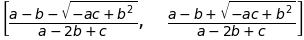

In [6]:
# 全く意味がないが2次方程式の解を求める
# -------------------------------------
from sympy import init_printing, pprint
from sympy import Symbol, symbols, factor, expand, solve
init_printing()
a, b, c, t = symbols('a, b, c, t')
x = (1 - t)**2 * a + 2 * (1 - t) *t * b + t**2 * c
x = expand(x)
x = factor(x)
solve(x, t)

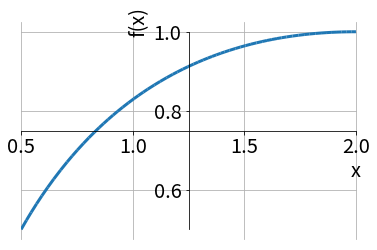

In [14]:
# 2次ベジェ曲線を t ではなく x について解く
# ------------------------------------------
from sympy import init_printing, pprint
from sympy import Symbol, symbols, factor, expand, solve, simplify
init_printing()

a_val = 0.5
b_val = 1.0
c_val = 2.0
p_val = 0.5
q_val = 1.0
r_val = 1.0

# x と t の関係式を記述
# ----------------------
a, b, c, t, x = symbols('a, b, c, t, x')
f = (1 - t)**2 * a + 2 * (1 - t) *t * b + t**2 * c - x

# x について解く
# ----------------------
t = solve(f, t)[1]
t = t.subs({a:a_val, b:b_val, c:c_val})

# y と t(ここでは u と置いた) の関係式を記述
# -------------------------------------------
p, q, r, u, y = symbols('p, q, r, u, y')
y = (1 - u)**2 * p + 2 * (1 - u) *u * q + u**2 * r

# パラメータ u と事前に求めた t で置き換える
# -------------------------------------------
y = y.subs({p:p_val, q:q_val, r:r_val, u:t})

from sympy.plotting import plot
plot(y, (x, a_val, c_val))